In [1]:
import math
import h5py
import os
import pandas as pd
import numpy as np
import cv2
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread 
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops

from glob import glob
np.random.seed(1)

<br>

*Reading Labels*

In [2]:
train_dir = 'C:\\Users\\Suryam Sharma\\MonkeyIdentification\\monkeySpecies\\training\\'
test_dir = 'C:\\Users\\Suryam Sharma\\MonkeyIdentification\\monkeySpecies\\validation\\'

In [3]:
cols = ['label','latinName', 'commonName','training_images', 'validation_images']
labels = pd.read_csv("C:\\Users\\Suryam Sharma\\MonkeyIdentification\\monkeySpecies\\monkey_labels.txt", names=cols, skiprows=1)
labels

,label,latinName,commonName,training_images,validation_images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


<br>

*Creating Data Frame for training*

In [4]:
for idx, row in labels.iterrows():
    path = train_dir+labels.label[idx].strip()+'\\'
    print(path)

C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n0\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n1\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n2\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n3\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n4\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n5\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n6\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n7\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n8\
C:\Users\Suryam Sharma\MonkeyIdentification\monkeySpecies\training\n9\


In [5]:
col_names =  ['path']
df_train  = pd.DataFrame(columns = col_names)
for idx, row in labels.iterrows():
    path = train_dir+labels.label[idx].strip()+'\\'
    df_temp = pd.DataFrame({'path': glob(os.path.join(path, '*.jpg'))})
    df_train = df_train.append(df_temp, ignore_index=True)
df_train['id'] = df_train.path.map(lambda x: x.split("\\")[7].split(".")[0])
df_train['label'] = df_train.path.map(lambda x: x.split("\\")[6].split("\\")[0])
#df_train['img'] = df_train['path'].map(imread)

In [6]:
df_train.head(3)

,path,id,label
0,C:\Users\Suryam Sharma\MonkeyIdentification\mo...,n0018,n0
1,C:\Users\Suryam Sharma\MonkeyIdentification\mo...,n0019,n0
2,C:\Users\Suryam Sharma\MonkeyIdentification\mo...,n0020,n0


In [7]:
col_names =  ['path']
df_test  = pd.DataFrame(columns = col_names)
for idx, row in labels.iterrows():
    path = test_dir+labels.label[idx].strip()+'\\'
    df_temp = pd.DataFrame({'path': glob(os.path.join(path, '*.jpg'))})
    df_test = df_test.append(df_temp, ignore_index=True)
df_test['id'] = df_test.path.map(lambda x: x.split("\\")[7].split(".")[0])
df_test['label'] = df_test.path.map(lambda x: x.split("\\")[6].split("\\")[0])


In [8]:
df_test.head(3)

,path,id,label
0,C:\Users\Suryam Sharma\MonkeyIdentification\mo...,n000,n0
1,C:\Users\Suryam Sharma\MonkeyIdentification\mo...,n001,n0
2,C:\Users\Suryam Sharma\MonkeyIdentification\mo...,n0010,n0


<br>

*Since the images are of different sizes, we'll need to pre-process them, to make them suitable for training*<br><br>
**Execute only once!!**
<br><br>

-----------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def augmentation(image, target_width=300, target_height=300, maxzoom = 0.2):
    height = image.shape[0]
    width = image.shape[1]
    ratio = height / width
    target_ratio = target_height / target_width
    if ratio < target_ratio:
        crop_width = width
        crop_height = int(height/target_ratio)
    else:
        crop_width = int(width * target_ratio)
        crop_height = height
    ### zoom in the picture from 1x to (1 + maxzon)x
    zoom_in_size = np.random.rand() * maxzoom + 1.0 
    crop_width = int(crop_width/zoom_in_size)
    crop_height = int(crop_height/zoom_in_size)
    
    ### randomly select the top-left point from 0 to width - crop_width
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    #print(x0,y0)
    image = image[y0:y1, x0:x1]
    
    ### 50% to flip flip right to left flip left to right
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
    
    image = scipy.misc.imresize(image,(target_height,target_width))
    image = cv2.GaussianBlur(image,(3,3),0)
    image = (image/255.) #* 2) - 1
    
    return image

In [ ]:
for idx, rows in df_train.iterrows():
    path = df_train.path[idx]
    img = Image.open(path)
    img.save(df_train.path[idx], dpi=(300, 300))

In [ ]:
for idx, rows in df_train.iterrows():
    path = df_train.path[idx]
    orig_img = cv2.imread(path)
    aug_img = augmentation(orig_img)
    aug_img = aug_img*255.
    cv2.imwrite(df_train.path[idx], aug_img)

In [ ]:
for idx, rows in df_test.iterrows():
    path = df_test.path[idx]
    img = Image.open(path)
    img.save(df_test.path[idx], dpi=(300, 300))

In [ ]:
for idx, rows in df_test.iterrows():
    path = df_test.path[idx]
    orig_img = cv2.imread(path)
    aug_img = augmentation(orig_img)
    aug_img = aug_img*255.
    cv2.imwrite(df_test.path[idx], aug_img)

In [ ]:
'''
path = 'C:\\Users\\Suryam Sharma\\MonkeyIdentification\\'
img = cv2.imread(path+'3.jpg')
aug_img = augmentation(img)
aug_img = aug_img*255.
cv2.imwrite(path+'out9.jpg', aug_img)
'''

-----------------------------------------------------------------------------------------------------------------------------------------------

<br>


<br>

*Display sample augmented image*

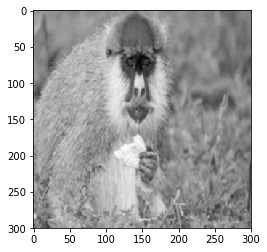

In [9]:
plt.imshow(cv2.imread(df_train.path[161], 0), 'gray')
plt.show()

<br>

*Now we need to flatten these 299x299x3 RGB image into 1-D array*<br>
*We'll now complete our dataframe, by adding flattened augmented images*

In [ ]:
#Skip this!

'''
df_train['flat_img'] = ""
for idx, row in df_train.iterrows():
    image = cv2.imread(df_train.path[idx], -1)
    image_flatten = np.reshape(image, [-1])
    image_flatten = image_flatten/255.
    df_train.flat_img[idx] = image_flatten
    
df_train.head(4)
'''

<br>

*Let's start by creating numpy arrays of training and test data...*


1) *Using the above training Dataframe, we'll create a numpy array 'train_x' using flattened images* <br>
2) *We'll also convert training labels to one hot matrix 'train_y*

In [9]:
global train_x
train_x = np.empty((1, 270000))

In [ ]:
#Skip this!
'''
for idx, row in df_train.iterrows():
    train_x = np.vstack((train_x, np.array((df_train.flat_img[idx]))))
'''

In [10]:
for idx, row in df_train.iterrows():
    image = cv2.imread(df_train.path[idx], -1)
    image_flatten = np.reshape(image, [-1])
    image_flatten = image_flatten/255.
    train_x = np.vstack((train_x, image_flatten))

In [11]:
train_x = train_x[1:]
train_x = train_x.T


In [12]:
print(train_x)
print('\n', "Shape:", train_x.shape)

[[0.15294118 0.15294118 0.31372549 ... 0.38039216 0.55294118 0.81960784]
 [0.36862745 0.34509804 0.74901961 ... 0.67843137 0.65490196 0.85490196]
 [0.39607843 0.26666667 0.6627451  ... 0.54509804 0.71764706 0.84313725]
 ...
 [0.07058824 0.54901961 0.29411765 ... 0.16862745 0.34901961 0.14117647]
 [0.45098039 0.89019608 0.85098039 ... 0.35294118 0.43137255 0.33333333]
 [0.49019608 0.85098039 0.5254902  ... 0.31764706 0.41960784 0.34117647]]

 Shape: (270000, 1096)


In [13]:
global test_x
test_x = np.empty((1, 270000))

In [14]:
for idx, row in df_test.iterrows():
    image = cv2.imread(df_test.path[idx], -1)
    image_flatten = np.reshape(image, [-1])
    image_flatten = image_flatten/255.
    test_x = np.vstack((test_x, image_flatten))

In [15]:
test_x = test_x[1:]
test_x = test_x.T

In [16]:
print(test_x)
print('\n', "Shape:", test_x.shape)

[[0.4627451  0.11372549 0.47058824 ... 0.03529412 0.19215686 0.41176471]
 [0.65490196 0.30980392 0.64313725 ... 0.33333333 0.29411765 0.87058824]
 [0.45882353 0.39607843 0.52156863 ... 0.2        0.23137255 0.74901961]
 ...
 [0.01176471 0.24313725 0.3372549  ... 0.30980392 0.98823529 0.36470588]
 [0.76078431 0.41176471 0.60784314 ... 0.6        0.99215686 0.45098039]
 [0.52156863 0.4        0.43921569 ... 0.41176471 0.98431373 0.40392157]]

 Shape: (270000, 272)


<br>

*Defining one hot matrix*

In [17]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [18]:
global train_y

In [19]:
train_y_orig = np.array(df_train.label)
train_y = np.empty((1096), dtype=np.int8)
labels = np.empty((1), dtype=np.int8)
for label in train_y_orig:
    label = label[1]
    labels = np.append(labels, int(label))
labels = labels[1:]
train_y = np.vstack((train_y, labels))
train_y = train_y[1:]
train_y = convert_to_one_hot(train_y, 10)

In [20]:
print(train_y)
print('\n', "Shape:", train_y.shape)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]

 Shape: (10, 1096)


In [21]:
global test_y

In [22]:
test_y_orig = np.array(df_test.label)
test_y = np.empty((272), dtype=np.int8)
labels = np.empty((1), dtype=np.int8)
for label in test_y_orig:
    label = label[1]
    labels = np.append(labels, int(label))
labels = labels[1:]
test_y = np.vstack((test_y, labels))
test_y = test_y[1:]
test_y = convert_to_one_hot(test_y, 10)

In [23]:
print(test_y)
print('\n', "Shape:", test_y.shape)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]

 Shape: (10, 272)


<br>

*We'll now create placeholders for X and Y. This will allow us to later pass our training data in, when we run our session.*

In [24]:
def create_placeholders(n_x, n_y):

#    Creates the placeholders for the tensorflow session.
    
#    Arguments:
#    n_x -- scalar, size of an image vector (num_px * num_px = 300 * 300 * 3 = 270000)
#    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
#    Returns:
#    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
#    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    X = tf.placeholder(tf.float32,shape= (n_x,None))
    Y = tf.placeholder(tf.float32,shape= (n_y,None))
    
    return X, Y

In [25]:
X, Y = create_placeholders(270000, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(270000, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(10, ?), dtype=float32)


<br>

**Initializing the parameters**<br>
*We'll be using Xavier Initialization for weights and Zero Initialization for biases.*

In [26]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [1024, 270000]
                        b1 : [1024, 1]
                        W2 : [256, 1024]
                        b2 : [256, 1]
                        W3 : [64, 256]
                        b3 : [64, 1]
                        W4 : [16, 64]
                        b4 : [16, 1]
                        W5 : [10, 16]
                        b5 : [10, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3, W4, b4
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [1024, 270000], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [1024,1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [256,1024], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [256,1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [64,256], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [64,1], initializer=tf.zeros_initializer())
    W4 = tf.get_variable("W4", [16,64], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable("b4", [16,1], initializer=tf.zeros_initializer())
    W5 = tf.get_variable("W5", [10,16], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b5 = tf.get_variable("b5", [10,1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5
                 }
    
    return parameters

<br>

**Forward Propogation**<br>
*The function will take in a dictionary of parameters and it will complete the forward pass.*

In [27]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4", "W5" & "b5"
                  the shapes are given in initialize_parameters

    Returns:
    Z5 -- the output of the last LINEAR unit
    """
    should_drop = tf.placeholder(tf.bool)
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']

    
                                                                    # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                 # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                             # A1 = relu(Z1)
    A1 = tf.contrib.layers.dropout(A1, keep_prob=0.6, is_training=True, seed=np.random.seed(1))         # Dropout 50% nodes 
    
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                             # A2 = relu(Z2)
    A2 = tf.contrib.layers.dropout(A2, keep_prob=0.8, is_training=True, seed=np.random.seed(1))         # Dropout 20% nodes
    
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                # Z3 = np.dot(W3,a2) + b3
    A3 = tf.nn.relu(Z3)                                             # A3 = relu(Z3)
    A3 = tf.contrib.layers.dropout(A3, keep_prob=0.9, is_training=True, seed=np.random.seed(1))         # Dropout 10% nodes
    
    Z4 = tf.add(tf.matmul(W4,A3),b4)                                # Z4 = np.dot(W4,a3) + b4
    A4 = tf.nn.relu(Z4)                                             # A4 = relu(Z4)
    
    Z5 = tf.add(tf.matmul(W5,A4),b5)                                # Z5 = np.dot(W5,a4) + b5
    
    return Z5

<br>

**Compute Cost**

In [28]:
def compute_cost(Z5, Y):
    """
    Computes the cost
    
    Arguments:
    Z5 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z5
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z5)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =logits, labels =labels))

    
    return cost

<br>

**Importing Random Mini Batches from: *tf_utils*** 

In [29]:
def random_mini_batches(X, Y, mini_batch_size, seed):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

<br>

**Model**

In [33]:
def model(X_train, Y_train, X_test, Y_test, num_epochs = 1500, minibatch_size = 32, learning_rate = 0.0001, print_cost = True):
    """
    Implements a four-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 270000, number of training examples = 1096)
    Y_train -- test set, of shape (output size = 10, number of training examples = 1096)
    X_test -- training set, of shape (input size = 270000, number of training examples = 272)
    Y_test -- test set, of shape (output size = 10, number of test examples = 272)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)


    # Initialize parameters
    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z5 = forward_propagation(X, parameters)

    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z5,Y)

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z5), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

<br>

**Let the training begin!!**

Cost after epoch 0: 2.410493
Cost after epoch 100: 1.776016
Cost after epoch 200: 1.382573
Cost after epoch 300: 1.037057
Cost after epoch 400: 0.753642
Cost after epoch 500: 0.570711
Cost after epoch 600: 0.458374
Cost after epoch 700: 0.325791
Cost after epoch 800: 0.244216
Cost after epoch 900: 0.198226
Cost after epoch 1000: 0.169391
Cost after epoch 1100: 0.140691
Cost after epoch 1200: 0.111528
Cost after epoch 1300: 0.093380
Cost after epoch 1400: 0.092628


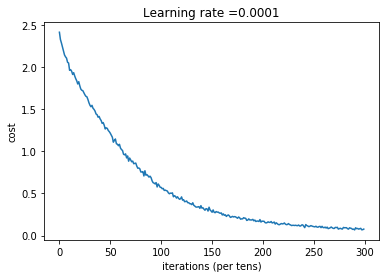

Parameters have been trained!
Train Accuracy: 0.99270076
Test Accuracy: 0.40441176


In [34]:
parameters = model(train_x, train_y, test_x, test_y)

<br>

**Predicting**

In [41]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])
    W5 = tf.convert_to_tensor(parameters["W5"])
    b5 = tf.convert_to_tensor(parameters["b5"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "W4": W4,
              "b4": b4,
              "W5": W5,
              "b5": b5}
    
    
    x = tf.placeholder("float", [270000, 1])
    
    z5 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z5)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [42]:
def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)                                    # A2 = relu(Z2)
    Z4 = tf.add(tf.matmul(W4, A3), b4)                     # Z4 = np.dot(W4,Z3) + b4
    A4 = tf.nn.relu(Z4)                                    # A2 = relu(Z2)
    Z5 = tf.add(tf.matmul(W5, A4), b5)                     # Z4 = np.dot(W4,Z3) + b4
    
    return Z5

<br>

*Visualizing prediction results*

In [37]:
global xtest
xtest = np.empty((1, 270000))

In [38]:
for idx, row in df_test.iterrows():
    image = cv2.imread(df_test.path[idx], -1)
    image_flatten = np.reshape(image, [-1])
    image_flatten = image_flatten/255.
    xtest = np.vstack((np.array((xtest)), image_flatten))

In [46]:
xtest = xtest[1:]

In [ ]:
df_test['pred_label']=""
for idx, rows in df_test.iterrows():
    test_img = np.array([xtest[idx]])
    y_pred = predict(test_img.T, parameters)
    df_test.pred_label[idx] = 'n'+str(np.squeeze(y_pred))
df_test.head(4)

In [ ]:
'''
count=0
for idx, rows in df_test.iterrows():
    if (df_test.label[idx] == df_test.pred_label[idx]):
        count = count + 1
print('Accuracy: ')
'''